# Dataset et problème posé

Le dataset fourni se nomme CVE. Il est disponible en suivant ce [lien](https://www.kaggle.com/datasets/andrewkronser/cve-common-vulnerabilities-and-exposures "source dataset cve").

Le dataset se compose de plusieurs colonnes, fournissant chacune une information sur une faille de sécurité, nommée par son nom de CWE. Common Weakness Enumeration ou CWE est une liste des vulnérabilités que l'on peut rencontrer dans les logiciels.
Le risque lié à chacune de ces 90 000+ failles sont définies par un score CVSS, qui varie entre 0 et 10, 0 étant un risque faible et 10 étant critique. Le CVSS, ou Common Vulnerability Scoring System, est un système d'évaluation standardisé de la criticité des vulnérabilités selon des critères objectifs et mesurables.

Le problème pourra donc être approché de deux manières :
- régression afin d'essayer de deviner le score exact du CVSS
- classification, si l'on regroupe le CVSS en classes (LOW, MEDIUM, HIGH, CRITICAL par exemple) selon leur valeur

Nous choisirons dans ce notebook l'approche régressive, qui permet à notre sens de limiter la perte d'information qu'induit le découpage en classes.

Cependant, avant d'être utilisable dans ce notebook, un gros travail de nettoyage doit être réalisé dans le fichier excel afin de retirer les commentaires ajouté aléatoirement, et standardiser le nombre de colonnes. Plus de 2000 lignes ont été retirées manuellement.

# Imports et constantes
## Import des librairies

In [66]:
# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew, kstest

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline 
# plt.style.use('fivethirtyeight') 

# PLOTLY 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns

# SCIKIT-LEARN: SELECTION DE VARIABLES
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# SCIKIT-LEARN: MODELES
from sklearn.dummy import DummyClassifier
from sklearn import linear_model # Classe Modèle linéaire 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet # Régression linéaire
from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression # Régression logistique
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR # Machines à vecteurs de support

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Découpage en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper_paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn import metrics
from sklearn.metrics import accuracy_score # Exactitude (accuracy)
from sklearn.metrics import f1_score # F1-score
from sklearn.metrics import confusion_matrix # Matrice de confusion
from sklearn.metrics import plot_confusion_matrix # Graphique de la matrice de confusion
from sklearn.metrics import classification_report # Rapport pour le modèle de classification
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

## EVALUATION: COURBE ROC
from sklearn.metrics import auc # Aire sous la courbe 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

# SCHIKIT-LEARN: PIPELINE et TRANSFORMATEUR
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

## ARBRES, FORETS, APRRENTISSAGE D'ENSEMBLE
from sklearn.tree import DecisionTreeClassifier # Arbres de décision (classification)
from sklearn.ensemble import RandomForestClassifier # Forêts aléatoires (classification)
from sklearn.ensemble import BaggingClassifier # Classifier Bagging (classification)
from sklearn.ensemble import AdaBoostClassifier # Classifier Adaboost (classification)
from sklearn.ensemble import GradientBoostingClassifier  # Gradient de boosting (classification)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparation des données en train et test set
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # tester arbitrairement plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données
 
# WARNINGS
import warnings
warnings.filterwarnings('ignore')

## Définition des constantes

In [2]:
# Path vers le dataset
#_DATASET_PATH_ = "./data/cve.csv"
# Setting du random state pour la reproduction à l'identique des tests
_RANDOM_STATE_ = 7
# Nom de la target
targetName = 'cvss'

## Import du dataset

In [3]:
 dataset = pd.read_csv("cve.csv", sep = ';')

# AED

In [4]:
 # Copie du dataset
df_data = dataset.copy()

In [5]:
df_data.head()

cve          mod_date          pub_date  cvss  cwe_code  \
0  CVE-2019-16548  21/11/2019 15:15  21/11/2019 15:15   6.8       352   
1  CVE-2019-16547  21/11/2019 15:15  21/11/2019 15:15   4.0       732   
2  CVE-2019-16546  21/11/2019 15:15  21/11/2019 15:15   4.3       639   
3   CVE-2013-2092  20/11/2019 21:22  20/11/2019 21:15   4.3        79   
4   CVE-2013-2091  20/11/2019 20:15  20/11/2019 20:15   7.5        89   

                                            cwe_name  \
0                  Cross-Site Request Forgery (CSRF)   
1   Incorrect Permission Assignment for Critical ...   
2   Authorization Bypass Through User-Controlled Key   
3   Improper Neutralization of Input During Web P...   
4   Improper Neutralization of Special Elements u...   

                                             summary access_authentication  \
0  A cross-site request forgery vulnerability in ...                   NaN   
1  Missing permission checks in various API endpo...                   NaN   
2  Jenkins Google Compute Engine Plugin 4.1.1 and...                   NaN   
3  Cross-site Scripting (XSS) in Dolibarr ERP/CRM...                   NaN   
4  SQL injection vulnerability in Dolibarr ERP/CR...                   NaN   

  access_complexity access_vector impact_availability impact_confidentiality  \
0               NaN           NaN                 NaN                    NaN   
1               NaN           NaN                 NaN                    NaN   
2               NaN           NaN                 NaN                    NaN   
3               NaN           NaN                 NaN                    NaN   
4               NaN           NaN                 NaN                    NaN   

  impact_integrity  Unnamed: 13  Unnamed: 14  Unnamed: 15  Unnamed: 16  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN          NaN          NaN          NaN   

   Unnamed: 17  Unnamed: 18  Unnamed: 19  Unnamed: 20  Unnamed: 21  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 22  Unnamed: 23 Unnamed: 24 Unnamed: 25 Unnamed: 26 Unnamed: 27  \
0          NaN          NaN         NaN         NaN         NaN         NaN   
1          NaN          NaN         NaN         NaN         NaN         NaN   
2          NaN          NaN         NaN         NaN         NaN         NaN   
3          NaN          NaN         NaN         NaN         NaN         NaN   
4          NaN          NaN         NaN         NaN         NaN         NaN   

  Unnamed: 28 Unnamed: 29 Unnamed: 30 Unnamed: 31 Unnamed: 32 Unnamed: 33  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 34 Unnamed: 35 Unnamed: 36 Unnamed: 37 Unnamed: 38 Unnamed: 39  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 40 Unnamed

L'affichage des 5 premières lignes du dataset nous donne une idée de la composition de ce dernier. Ici, on remarque la target, qui est une valeur continue flottante, 'cwe_code' qui est entière, et les autres qui semblent soit textuelles, soit manquantes.

In [6]:
# Afficher la taille du dataset
n_samples, n_features = df_data.shape
print("Nombre de lignes:", n_samples)
print("Nombre de colonnes:", n_features)

Nombre de lignes: 89531
Nombre de colonnes: 97


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89531 entries, 0 to 89530
Data columns (total 97 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cve                     89531 non-null  object 
 1   mod_date                89531 non-null  object 
 2   pub_date                89531 non-null  object 
 3   cvss                    89531 non-null  float64
 4   cwe_code                89531 non-null  int64  
 5   cwe_name                89531 non-null  object 
 6   summary                 89531 non-null  object 
 7   access_authentication   85401 non-null  object 
 8   access_complexity       85401 non-null  object 
 9   access_vector           85401 non-null  object 
 10  impact_availability     85401 non-null  object 
 11  impact_confidentiality  85401 non-null  object 
 12  impact_integrity        85401 non-null  object 
 13  Unnamed: 13             0 non-null      float64
 14  Unnamed: 14             0 non-null    

Une grosse partie des colonnes ne possèdent que quelques valeurs non nulles. Elles ne sont donc pas exploitables en tant que telles, et il faut s'interroger sur l'utilité de ces dernières. Cependant, on peut supprimer les colonnes 13 à 23 qui contiennent uniquement des valeurs nulles.

In [8]:
df_data.drop(df_data.iloc[:, 13:24], inplace = True, axis = 1)

On peut maintenant observer le comportement des variables quand la features 96 n'est pas nulle :

In [9]:
df_data.loc[df_data['Unnamed: 96'].notnull()].head()

cve          mod_date          pub_date  cvss  cwe_code  \
44010  CVE-2017-17144  29/03/2018 14:21  05/03/2018 19:29   5.0       119   
44089  CVE-2017-17143  27/03/2018 20:41  05/03/2018 19:29   5.0       119   
44090  CVE-2017-17142  27/03/2018 20:40  05/03/2018 19:29   5.0       119   

                                                cwe_name  \
44010   Improper Restriction of Operations within the...   
44089   Improper Restriction of Operations within the...   
44090   Improper Restriction of Operations within the...   

                                                 summary  \
44010  Backup feature of SIP module in Huawei DP300 V...   
44089             SIP module in Huawei DP300 V500R002C00   
44090             SIP module in Huawei DP300 V500R002C00   

      access_authentication access_complexity access_vector  \
44010                   NaN               NaN           NaN   
44089                   NaN               NaN           NaN   
44090                   NaN               NaN           NaN   

      impact_availability impact_confidentiality impact_integrity  \
44010                 NaN                    NaN              NaN   
44089                 NaN                    NaN              NaN   
44090                 NaN                    NaN              NaN   

              Unnamed: 24         Unnamed: 25         Unnamed: 26  \
44010   V100R001C10SPC300   V100R001C10SPC500   V100R001C10SPC600   
44089   V100R001C10SPC300   V100R001C10SPC500   V100R001C10SPC600   
44090   V100R001C10SPC300   V100R001C10SPC500   V100R001C10SPC600   

                  Unnamed: 27         Unnamed: 28         Unnamed: 29  \
44010   V100R001C10SPC700B010   V100R001C10SPC800   V500R002C00SPC200   
44089   V100R001C10SPC700B010   V100R001C10SPC800   V500R002C00SPC200   
44090   V100R001C10SPC700B010   V100R001C10SPC800   V500R002C00SPC200   

              Unnamed: 30         Unnamed: 31         Unnamed: 32  \
44010   V500R002C00SPC500   V500R002C00SPC600   V500R002C00SPC700   
44089   V500R002C00SPC500   V500R002C00SPC600   V500R002C00SPC700   
44090   V500R002C00SPC500   V500R002C00SPC600   V500R002C00SPC700   

              Unnamed: 33         Unnamed: 34   Unnamed: 35  \
44010   V500R002C00SPC900   V500R002C00SPCb00   V600R006C00   
44089   V500R002C00SPC900   V500R002C00SPCb00   V600R006C00   
44090   V500R002C00SPC900   V500R002C00SPCb00   V600R006C00   

                   Unnamed: 36         Unnamed: 37         Unnamed: 38  \
44010   TE40 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPC900   
44089   TE40 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPC900   
44090   TE40 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPC900   

              Unnamed: 39   Unnamed: 40         Unnamed: 41  \
44010   V500R002C00SPCb00   V600R006C00   V600R006C00SPC200   
44089   V500R002C00SPCb00   V600R006C00   V600R006C00SPC200   
44090   V500R002C00SPCb00   V600R006C00   V600R006C00SPC200   

                   Unnamed: 42         Unnamed: 43         Unnamed: 44  \
44010   TE50 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPCb00   
44089   TE50 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPCb00   
44090   TE50 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPCb00   

        Unnamed: 45         Unnamed: 46              Unnamed: 47  \
44010   V600R006C00   V600R006C00SPC200   TE60 V100R001C01SPC100   
44089   V600R006C00   V600R006C00SPC200   TE60 V100R001C01SPC100   
44090   V600R006C00   V600R006C00SPC200   TE60 V100R001C01SPC100   

                   Unnamed: 48   Unnamed: 49         Unnamed: 50  \
44010   V100R001C01SPC107TB010   V100R001C10   V100R001C10SPC300   
44089   V100R001C01SPC107TB010   V100R001C10   V100R001C10SPC300   
44090   V100R001C01SPC107TB010   V100R001C10   V100R001C10SPC300   

              Unnamed: 51         Unnamed: 52         Unnamed: 53  \
44010   V100R001C10SPC400   V100R001C10SPC500   V100R001C10SPC600   
44089   V100R001C10SPC400   V100R001C10SPC500   V100R001C10SPC600 

On remarque que sur les 3 lignes non nulles de la feature 96, toutes les colonnes en partant de la 24 sont remplies.

## Donnees continues (Target)

In [10]:
con_features = df_data.select_dtypes(include=['float64']).columns
print(con_features)

Index(['cvss'], dtype='object')


In [11]:
print(f'{np.sort(df_data[targetName].unique())}')

[ 0.   1.2  1.3  1.5  1.7  1.8  1.9  2.1  2.3  2.4  2.6  2.7  2.8  2.9
  3.   3.2  3.3  3.5  3.6  3.7  3.8  4.   4.1  4.3  4.4  4.6  4.7  4.8
  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2
  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6
  7.7  7.8  7.9  8.   8.2  8.3  8.5  8.7  8.8  9.   9.3  9.4  9.7 10. ]


Seule la target est une colonne continue, évoluant de 0 à 10. Aucune transformation ne semble nécessaire pour l'utiliser comem telle. Cependant, pour la majorité des modèles de Machine Learning, il convient de vérifier que la courbe de densité de la target soit à peu près normale (forme gaussienne) afin de pouvoir l'utiliser.

<AxesSubplot:xlabel='cvss', ylabel='Density'>

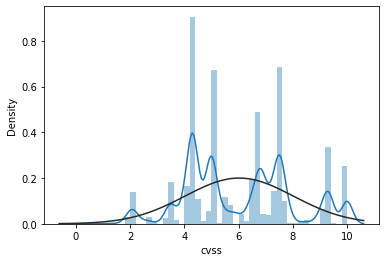

In [12]:
sns.distplot(df_data[targetName], fit=norm)

Comme on peut le voir ici, la target n'est pas du tout gaussienne (courbe noire : gaussienne attendue, courbe bleue : répartition de la target). Il faudra donc essayer de la réduire et de la centrer avec une log-transformation.

In [13]:
con_features.drop(targetName)

Index([], dtype='object')

On peut supprimer la target des features continues, car on ne veut pas appliquer de pré-traitements dessus (scaling etc.).

## Donnees categorielles

In [14]:
cat_features = df_data.select_dtypes(include=['int64','object']).columns
print(cat_features)

Index(['cve', 'mod_date', 'pub_date', 'cwe_code', 'cwe_name', 'summary',
       'access_authentication', 'access_complexity', 'access_vector',
       'impact_availability', 'impact_confidentiality', 'impact_integrity',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43',
       'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47',
       'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51',
       'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55',
       'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59',
       'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63',
       'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67',
       'Unnamed: 68', 'Unnamed: 69', 'Unname

L'intégralité des colonnes semblent catégorielles à par la target 

In [15]:
df_data["cwe_name"].value_counts()

 Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')           12325
 Improper Restriction of Operations within the Bounds of a Memory Buffer                        12325
 Improper Input Validation                                                                       7869
 Information Exposure                                                                            6592
 Permissions Privileges and Access Controls                                                      5813
 Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')            5740
 Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')                  3062
 Resource Management Errors                                                                      2960
 Cryptographic Issues                                                                            2552
 Cross-Site Request Forgery (CSRF)                                                

On remarque que cette colonne contient des noms de CWE, qui sont donc des catégories. Il n'y a pas besoin de réaliser de NLP sur cette colonne car ce sont justement des catégories que l'on pourra encoder par la suite.

In [16]:
df_data["cwe_code"].value_counts()

79      12325
119     12325
20       7869
200      6592
264      5813
89       5740
22       3062
399      2960
310      2552
352      2415
94       2412
125      2105
287      1801
284      1658
189      1363
416      1340
190      1134
476       971
255       967
787       853
78        829
362       643
400       576
254       568
59        541
77        520
434       447
732       423
611       420
295       391
269       390
74        366
798       342
772       324
426       301
601       278
502       277
16        248
19        238
134       218
835       217
918       207
704       196
522       186
415       174
17        163
532       162
863       156
275       155
384       124
326       121
369       117
285       117
120       109
862       106
306        98
276        93
347        82
770        81
319        81
617        80
129        78
427        76
668        72
345        72
327        71
320        65
404        61
640        60
311        58
191        55
388   

On remarque un détail intéressant dans ce dataset. La colonne 'cwe_code' est un encodage des valeurs de 'cwe_name'. De ce fait, nous pouvons supprimer la valeur non encodée.

In [17]:
df_data=df_data.drop(['cwe_name', ],axis=1)

In [18]:
cat_features = df_data.select_dtypes(include=['int64','object']).columns
for feature in cat_features:
    print(f'{feature :-<30} {df_data[feature].unique()}')

cve--------------------------- ['CVE-2019-16548' 'CVE-2019-16547' 'CVE-2019-16546' ... 'CVE-2007-6442'
 'CVE-2007-6370' 'CVE-2007-3004']
mod_date---------------------- ['21/11/2019 15:15' '20/11/2019 21:22' '20/11/2019 20:15' ...
 '11/02/2008 05:00' '21/01/2008 05:00' '10/01/2008 05:00']
pub_date---------------------- ['21/11/2019 15:15' '20/11/2019 21:15' '20/11/2019 20:15' ...
 '24/07/2007 17:30' '11/04/2003 04:00' '10/01/2008 01:46']
cwe_code---------------------- [ 352  732  639   79   89  200   20  319  276  269  426   74  362  273
  416   59  611  434  287   22  295  400   78  125  190  476  532  119
  668  120  307  787  522  754  863  755  610  862  772  384  613  354
  327  290  134  617  918  415  345  494  311  502  835  674  798  824
   91  330  347  312 1188  640  916  704  601  264  306  829  129 1187
  521  338  665  331  326  776   94  294  399  404  843  254  428  552
 1021  770  669  367  255  436  191  427  444  565  284  189  310   77
  275  369  924  285  281  682 

On remarque ici que la plupart des valeurs catégorielles sont encodables, notamment les colonnes 'access_authentication', 'complexity', 'access_vector', 'impact_availability', 'impact_confidentiality', et 'impact_integrity' qui possèdent peu de catégories. A l'inverse, la colonne summary possède énormément de valeurs différentes (plus que 30, et quasiment une valeur différente par ligne), ce qui impliquerait une utilisation de NLP (en passant par un réseau de neurones adapté), donc nous allons la retirer du dataset pour le moment. Si aucun modèle classique de régression ne donne de résultat probant, on pourra s'interroger sur l'utilisation de Tensorflow ou une librairie concurrente.

In [19]:
df_data=df_data.drop(['summary'],axis=1)

In [20]:
dfMissvalues = pd.DataFrame(
                           (round(100* df_data.isnull().sum()/len(df_data), 2)), 
                           columns=['Pourcentage valeurs manquantes']
                           )
dfMissvalues.sort_values(by=['Pourcentage valeurs manquantes'], ascending=False)

Pourcentage valeurs manquantes
Unnamed: 96                                     100.00
Unnamed: 81                                     100.00
Unnamed: 66                                     100.00
Unnamed: 67                                     100.00
Unnamed: 68                                     100.00
Unnamed: 69                                     100.00
Unnamed: 70                                     100.00
Unnamed: 71                                     100.00
Unnamed: 72                                     100.00
Unnamed: 73                                     100.00
Unnamed: 74                                     100.00
Unnamed: 75                                     100.00
Unnamed: 76                                     100.00
Unnamed: 78                                     100.00
Unnamed: 79                                     100.00
Unnamed: 80                                     100.00
Unnamed: 77                                     100.00
Unnamed: 82                                     100.00
Unnamed: 89                                     100.00
Unnamed: 95                                     100.00
Unnamed: 94                                     100.00
Unnamed: 83                                     100.00
Unnamed: 92                                     100.00
Unnamed: 91                                     100.00
Unnamed: 90                                     100.00
Unnamed: 93                                     100.00
Unnamed: 88                                     100.00
Unnamed: 87                                     100.00
Unnamed: 86                                     100.00
Unnamed: 85                                     100.00
Unnamed: 84                                     100.00
Unnamed: 56                                      99.99
Unnamed: 65                                      99.99
Unnamed: 64                                      99.99
Unnamed: 63                                      99.99
Unnamed: 62                                      99.99
Unnamed: 61                                      99.99
Unnamed: 60                                      99.99
Unnamed: 59                                      99.99
Unnamed: 58                                      99.99
Unnamed: 57                                      99.99
Unnamed: 55                                      99.99
Unnamed: 34                                      99.99
Unnamed: 43                                      99.99
Unnamed: 32                                      99.99
Unnamed: 33                                      99.99
Unnamed: 54                                      99.99
Unnamed: 35                                      99.99
Unnamed: 37                                      99.99
Unnamed: 38                                      99.99
Unnamed: 39                                      99.99
Unnamed: 40                                      99.99
Unnamed: 41                                      99.99
Unnamed: 42                                      99.99
Unnamed: 36                                      99.99
Unnamed: 44                                      99.99
Unnamed: 46                                      99.99
Unnamed: 47                                      99.99
Unnamed: 48                                      99.99
Unnamed: 49                                      99.99
Unnamed: 50                                      99.99
Unnamed: 51                                      99.99
Unnamed: 52                                      99.99
Unnamed: 53                                      99.99
Unnamed: 45                                      99.99
Unnamed: 27                                      99.98
Unnamed: 24                                      99.98
Unnamed: 25                                      99.98
Unnamed: 26                                      99.98
Unnamed: 29                                      99.98
Unnamed: 28                                      99.98
Unnamed: 30                                      99.98
Unnamed: 

On remarque que certaines variables possèdent quasiment 100% de valeurs manquantes. Elles ne sont donc pas exploitables. De ce fait, nous pouvons les supprimer.

In [21]:
miss_rates = df_data.isna().sum() / len(df_data)
features = df_data.columns[miss_rates  < 0.9]
df_data = df_data[features]                 

In [22]:
df_data.shape

(89531, 11)

Le dataset possède maintenant une taille réduite de beaucoup, passant de quasiment 100 colonnes à 13. On remarque cependant que certaines colonnes peuvent encore être supprimer, comme par exemple 'cve' qui ne représente que le nom de la CVE et agit donc comme un ID.

In [23]:
df_data=df_data.drop(['cve'],axis=1)

Il faut maintenant gérer les dates. En effet, au format donné, les dates ne sont pas exploitables par nos algorithmes de Machine Learning, et par conséquent ne peuvent entrer en compte dans la modélisation. On peut cependant supposer qu'elles jouent un rôle plus ou moins important dans l'évaluation de la CVSS, par exemple si les failles découvertes à certains moments de la journée donnent un score plus élevé sur la dangerosité de cette dernière.

In [24]:
# Coupage de la colonne 'mod_date'
df_data['mod_minute'] = pd.to_datetime(df_data['mod_date']).dt.minute
df_data['mod_hour'] = pd.to_datetime(df_data['mod_date']).dt.hour
df_data['mod_day'] = pd.to_datetime(df_data['mod_date']).dt.day
df_data['mod_month'] = pd.to_datetime(df_data['mod_date']).dt.month
df_data['mod_year'] = pd.to_datetime(df_data['mod_date']).dt.year
df_data = df_data.drop(['mod_date'], axis=1)

# Coupage de la colonne 'pub_date'
df_data['pub_minute'] = pd.to_datetime(df_data['pub_date']).dt.minute
df_data['pub_hour'] = pd.to_datetime(df_data['pub_date']).dt.hour
df_data['pub_day'] = pd.to_datetime(df_data['pub_date']).dt.day
df_data['pub_month'] = pd.to_datetime(df_data['pub_date']).dt.month
df_data['pub_year'] = pd.to_datetime(df_data['pub_date']).dt.year
df_data = df_data.drop(['pub_date'], axis=1)

In [25]:
df_data.head()

cvss  cwe_code access_authentication access_complexity access_vector  \
0   6.8       352                   NaN               NaN           NaN   
1   4.0       732                   NaN               NaN           NaN   
2   4.3       639                   NaN               NaN           NaN   
3   4.3        79                   NaN               NaN           NaN   
4   7.5        89                   NaN               NaN           NaN   

  impact_availability impact_confidentiality impact_integrity  mod_minute  \
0                 NaN                    NaN              NaN          15   
1                 NaN                    NaN              NaN          15   
2                 NaN                    NaN              NaN          15   
3                 NaN                    NaN              NaN          22   
4                 NaN                    NaN              NaN          15   

   mod_hour  mod_day  mod_month  mod_year  pub_minute  pub_hour  pub_day  \
0        15       21         11      2019          15        15       21   
1        15       21         11      2019          15        15       21   
2        15       21         11      2019          15        15       21   
3        21       20         11      2019          15        21       20   
4        20       20         11      2019          15        20       20   

   pub_month  pub_year  
0         11      2019  
1         11      2019  
2         11      2019  
3         11      2019  
4         11      2019

Le fait d'avoir éclaté la date en plusieurs colonnes nous permet de les utiliser maintenant dans nos modèles, car le format est compatible avec les approches de modélisation.

In [26]:
cat_features = df_data.select_dtypes(include=['int64','object']).columns

In [27]:
print("Colonnes catégorielles:\n\n", cat_features.values)

Colonnes catégorielles:

 ['cwe_code' 'access_authentication' 'access_complexity' 'access_vector'
 'impact_availability' 'impact_confidentiality' 'impact_integrity'
 'mod_minute' 'mod_hour' 'mod_day' 'mod_month' 'mod_year' 'pub_minute'
 'pub_hour' 'pub_day' 'pub_month' 'pub_year']


In [28]:
# Afficher la taille du dataset
n_samples, n_features = df_data.shape
print("Nombre de lignes:", n_samples)
print("Nombre de colonnes:", n_features)

Nombre de lignes: 89531
Nombre de colonnes: 18


Finalement, nous obtenons 18 colonnes, la réduction est donc impressionnante par rapport au dataset de départ, ce qui rend le problème plus compréhensible.

## Valeurs manquantes

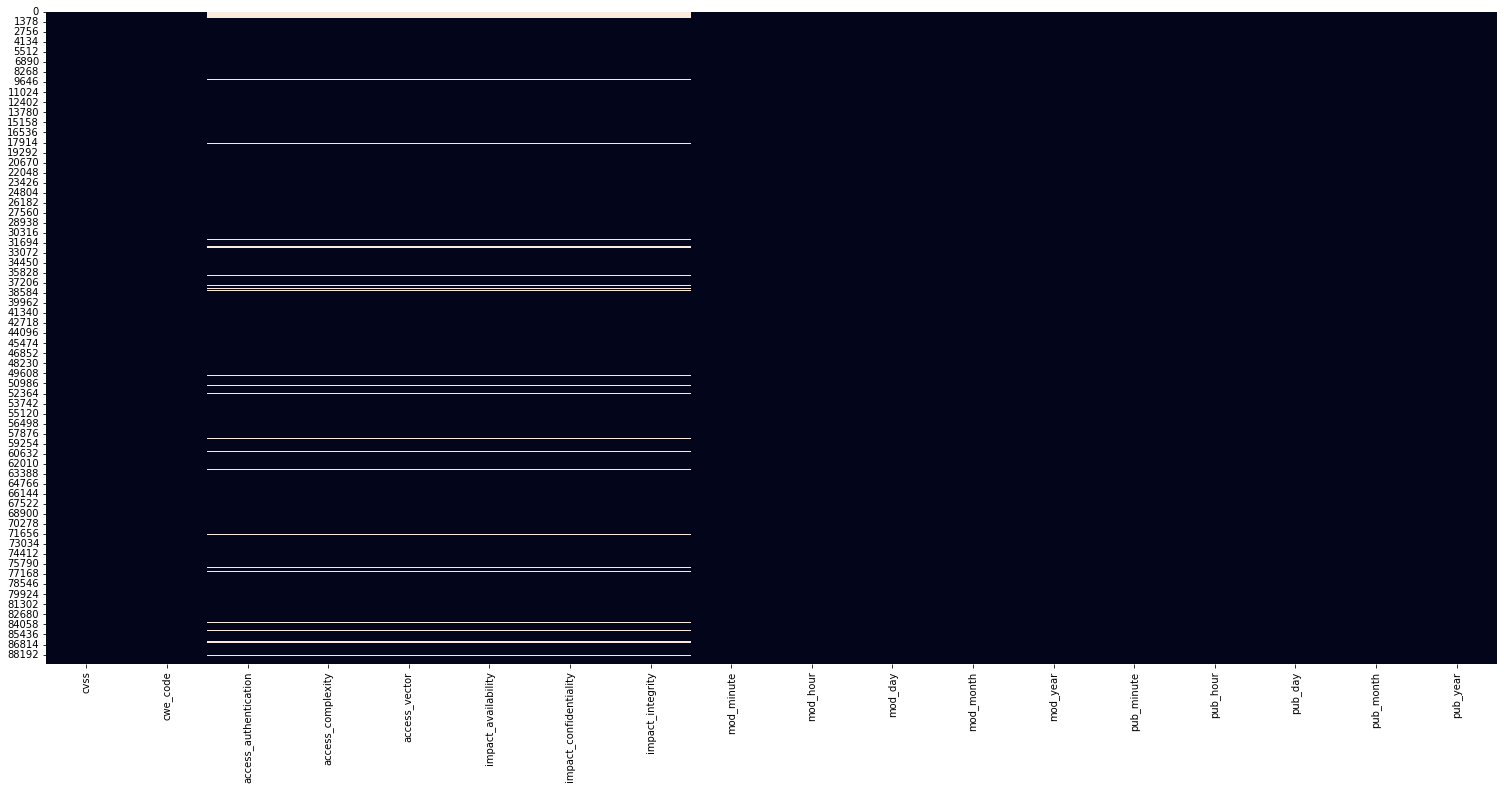

In [29]:
# Afficher tous les na
plt.figure(figsize=(26, 12))
sns.heatmap(df_data.isna(), cbar=False)
plt.show()

Pour ce qui reste des colonnes, les valeurs manquantes sont assez faibles, et toutes présentes sur 6 colonnes. Il faudra donc penser à utiliser un imputer lors des pré-traitements afin de combler ces valeurs avec les modes ou les k plus proches voisins par exemples.

## Analyse bivariée entre les features

### Corrélation avec les valeurs catégorielles entières et continues

In [30]:
corrmat = df_data.corr()

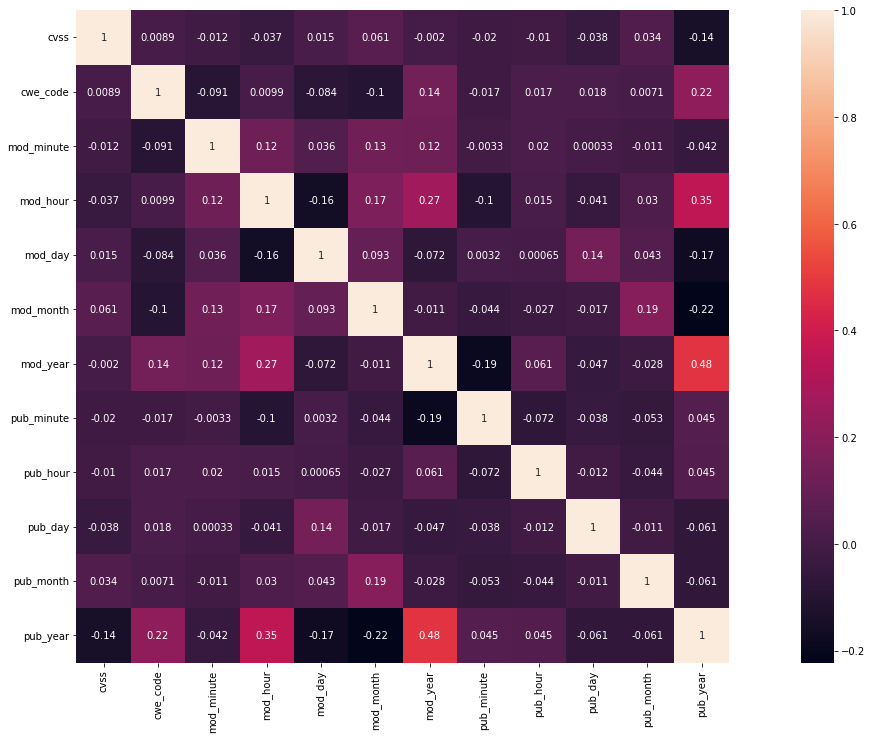

In [31]:
plt.figure(figsize=(26, 12))
sns.heatmap(corrmat, annot=True, cbar=True, square=True, vmax=1)
plt.show()

In [32]:
print(corrmat)

                cvss  cwe_code  mod_minute  mod_hour   mod_day  mod_month  \
cvss        1.000000  0.008936   -0.012434 -0.036548  0.014663   0.061450   
cwe_code    0.008936  1.000000   -0.090925  0.009906 -0.083563  -0.101448   
mod_minute -0.012434 -0.090925    1.000000  0.119121  0.035701   0.134383   
mod_hour   -0.036548  0.009906    0.119121  1.000000 -0.164237   0.165034   
mod_day     0.014663 -0.083563    0.035701 -0.164237  1.000000   0.092714   
mod_month   0.061450 -0.101448    0.134383  0.165034  0.092714   1.000000   
mod_year   -0.002000  0.136709    0.116638  0.266811 -0.071939  -0.011458   
pub_minute -0.019658 -0.017412   -0.003303 -0.100567  0.003219  -0.043743   
pub_hour   -0.010110  0.017498    0.020329  0.014949  0.000645  -0.027473   
pub_day    -0.038241  0.017597    0.000334 -0.041161  0.140743  -0.016951   
pub_month   0.033502  0.007147   -0.010573  0.030069  0.042998   0.190277   
pub_year   -0.141871  0.218662   -0.042195  0.350713 -0.173652  -0.222543   

On remarque qu'il n'y a pas de corrélation linéaire significative entre la valeur 'cve_code' et la target. Cela fait sens, car le code n'est qu'une valeur encodée et non une quantité. A l'inverse, les colonnes 'mod_year' et 'pub_year' ont une corrélation linéaire assez fortes, ce qui est assez logique. Pourtant, elle ne vaut que 0.43, ce qui signifie que plus de la moitié du temps il y'a un décalage d'au moins un an entre la publication et la modification.

### Corrélation avec les valeurs catégorielles

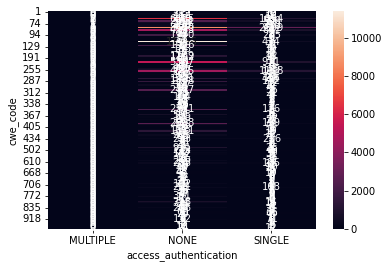

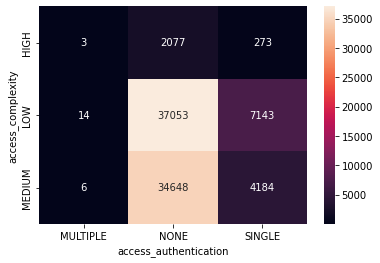

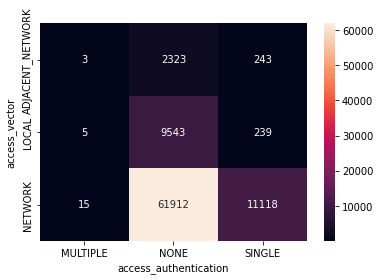

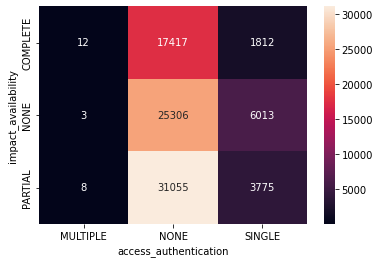

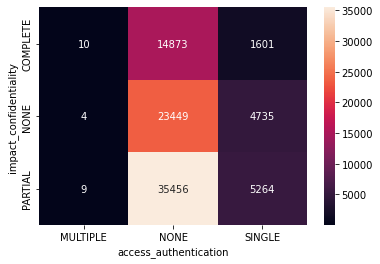

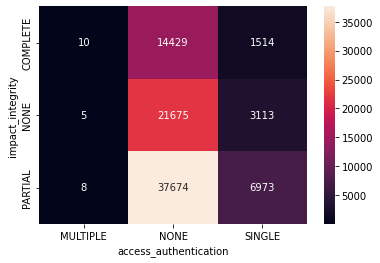

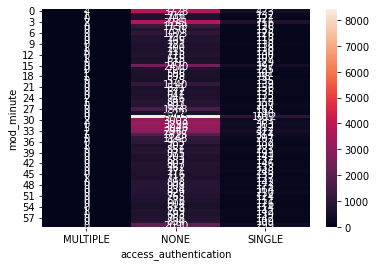

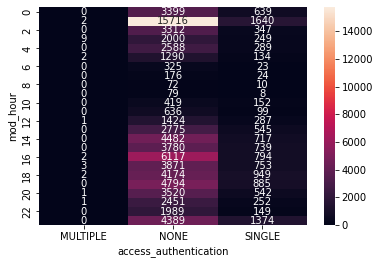

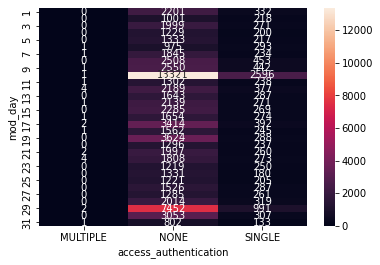

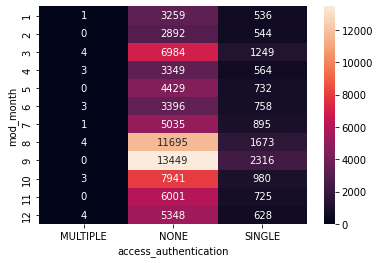

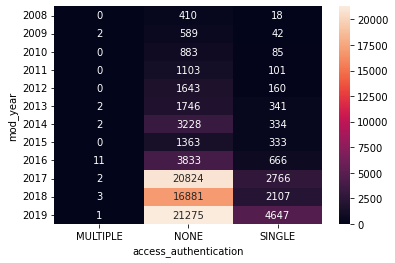

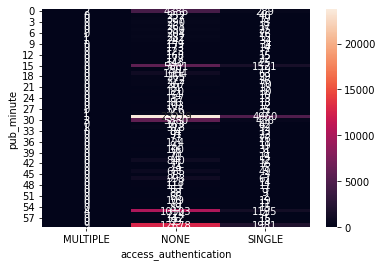

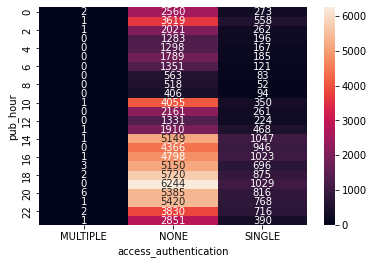

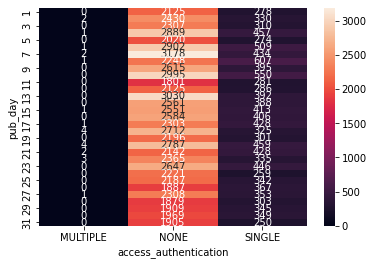

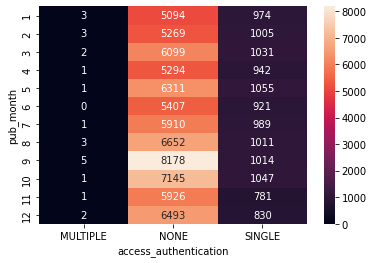

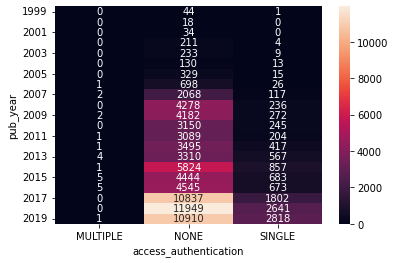

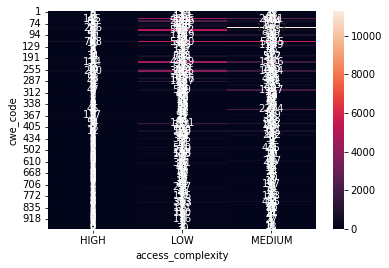

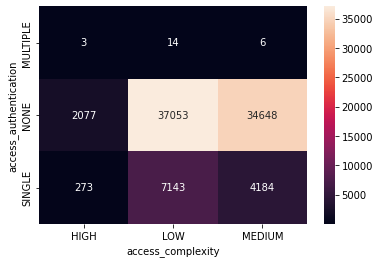

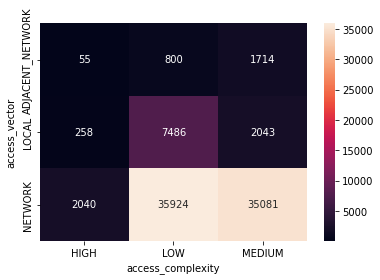

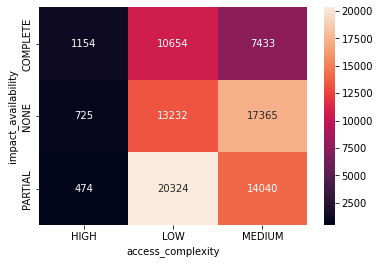

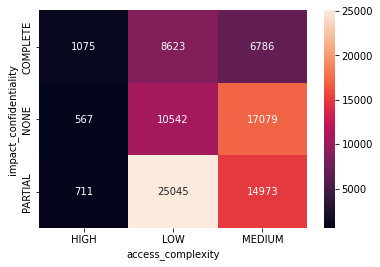

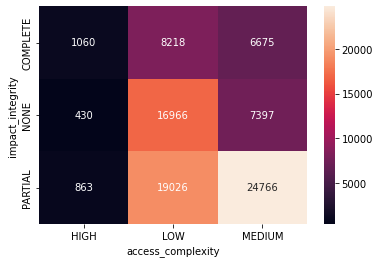

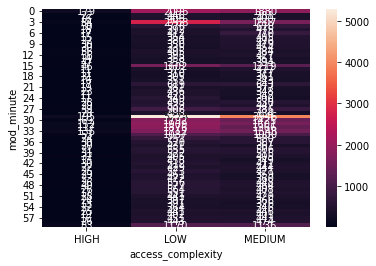

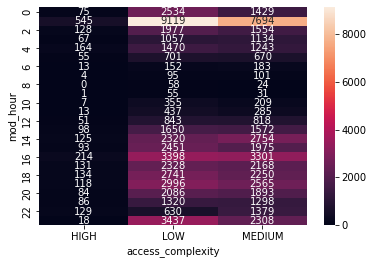

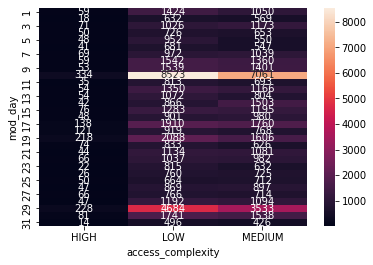

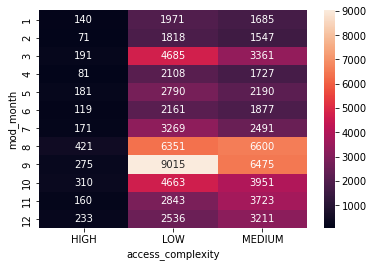

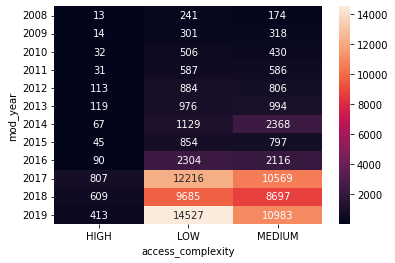

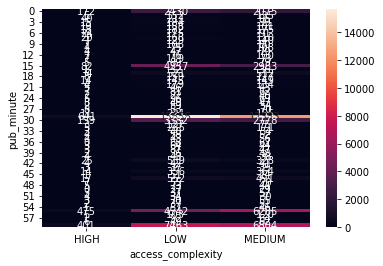

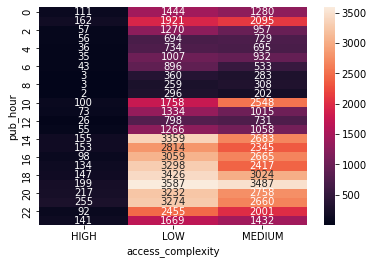

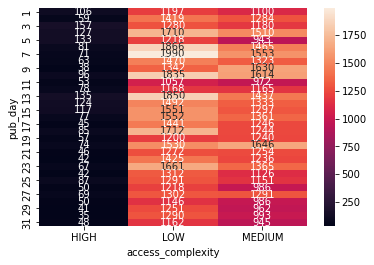

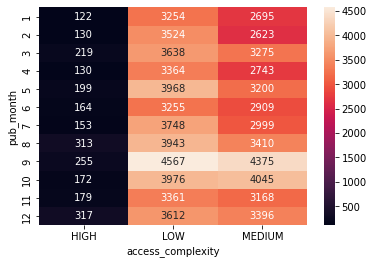

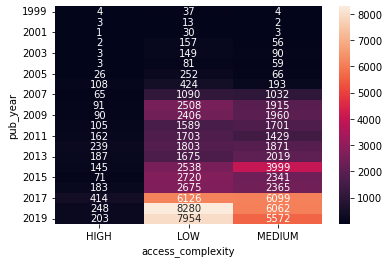

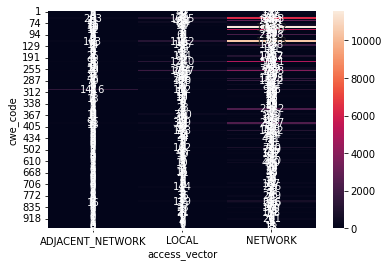

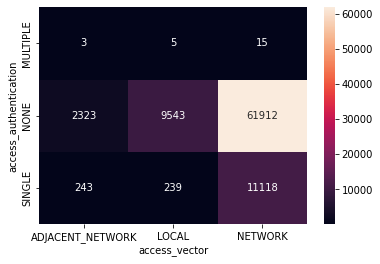

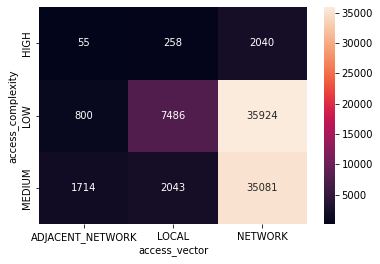

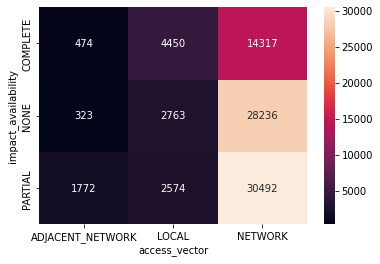

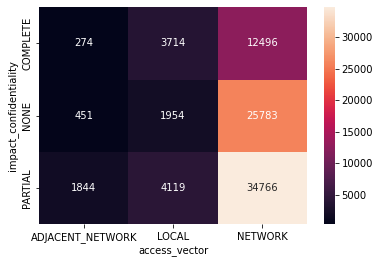

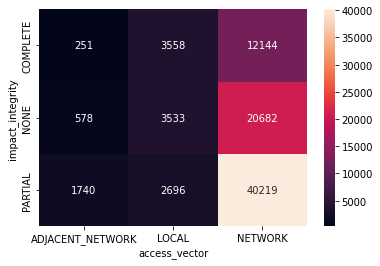

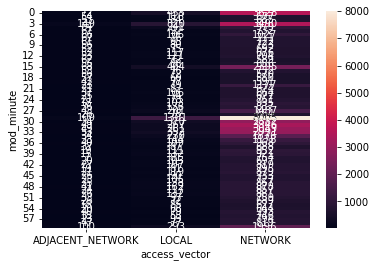

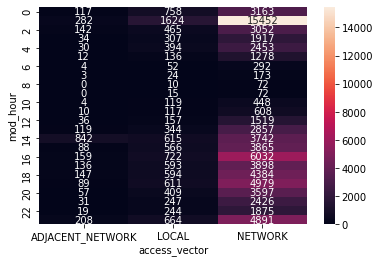

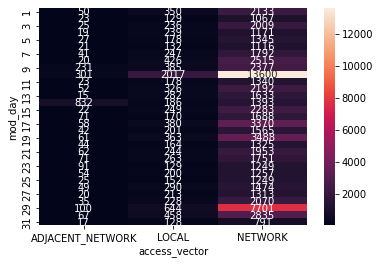

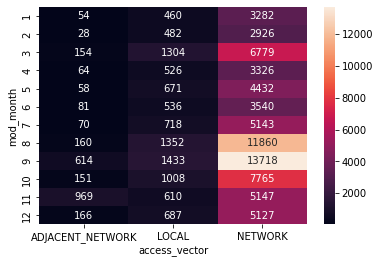

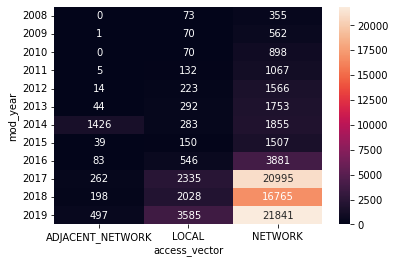

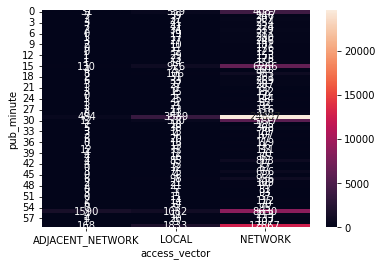

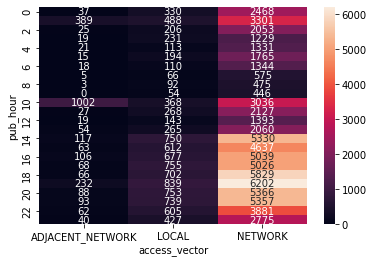

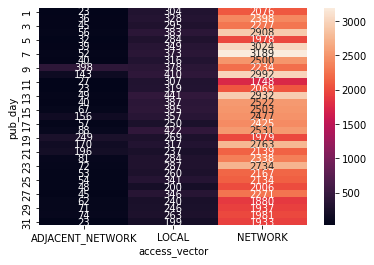

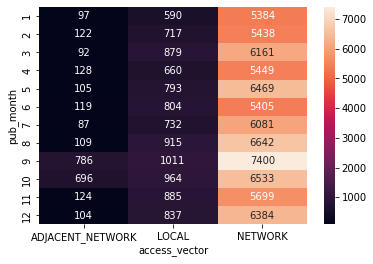

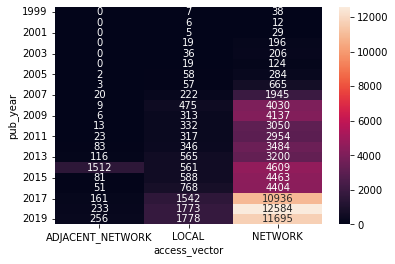

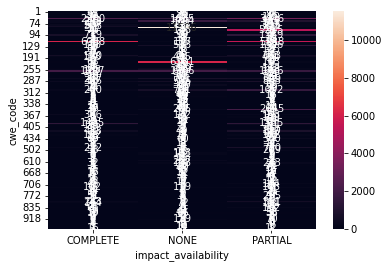

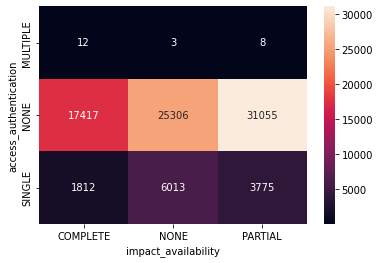

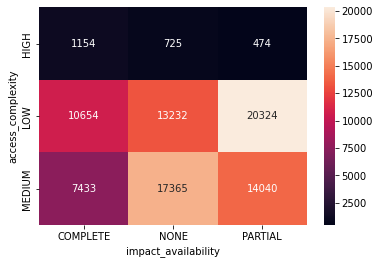

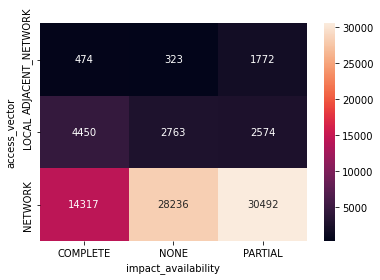

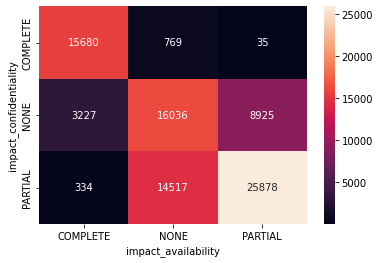

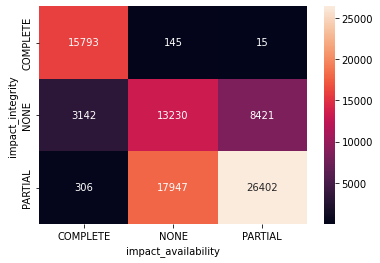

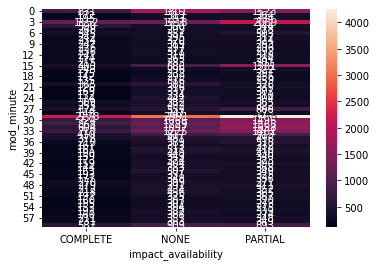

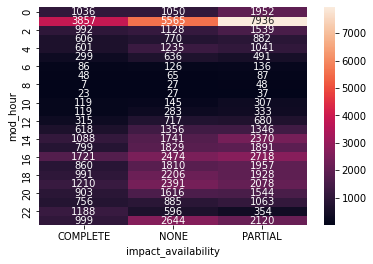

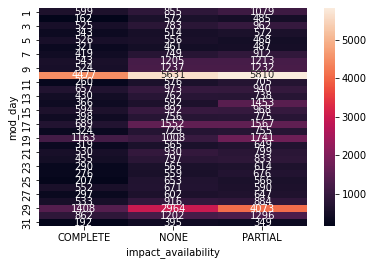

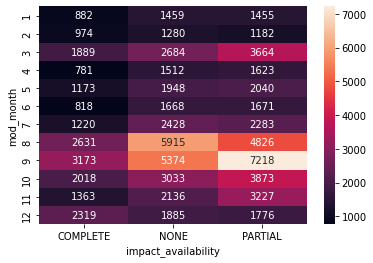

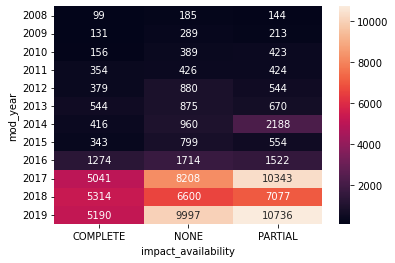

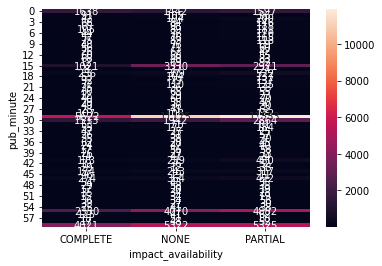

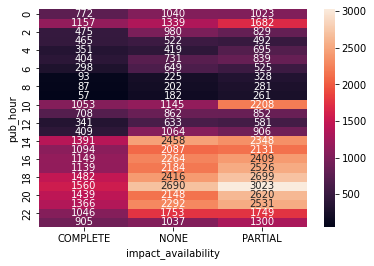

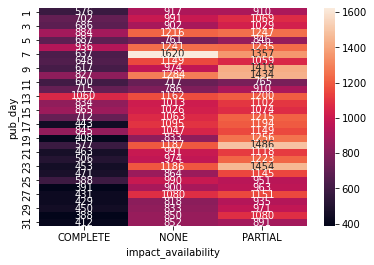

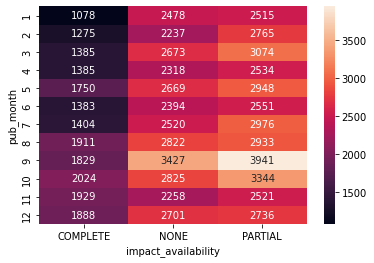

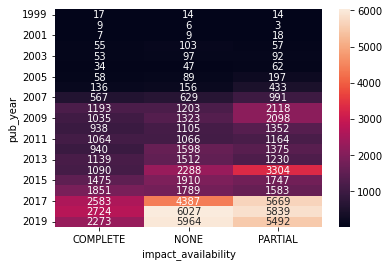

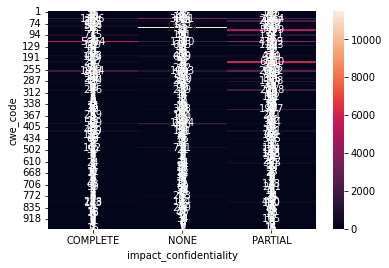

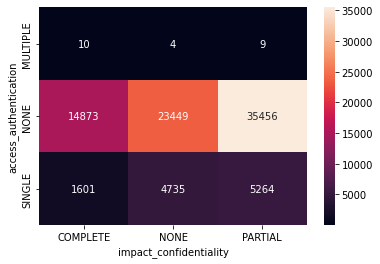

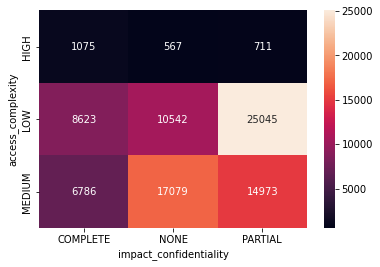

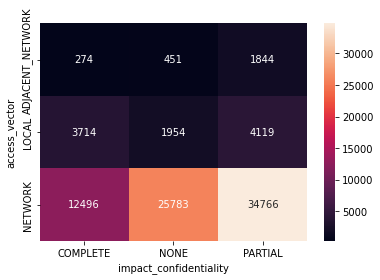

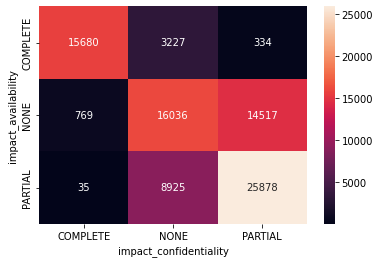

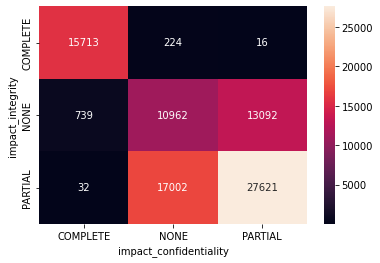

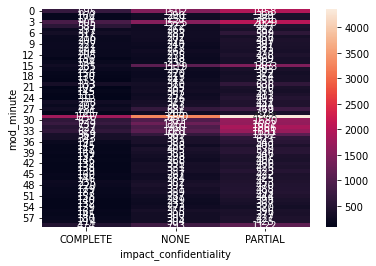

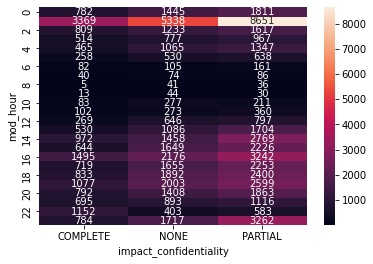

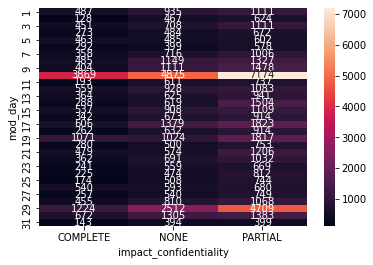

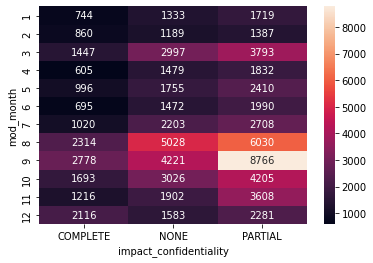

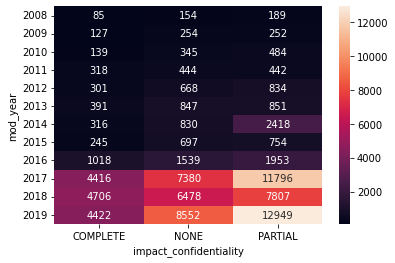

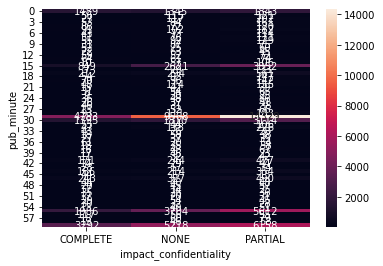

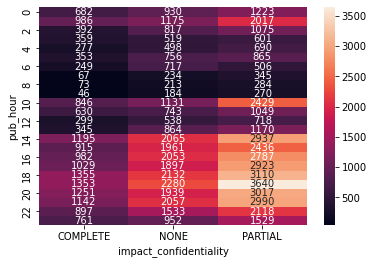

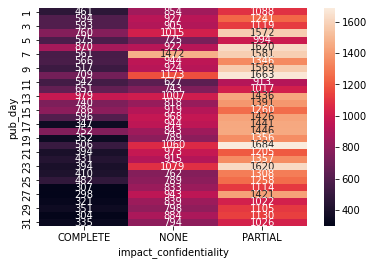

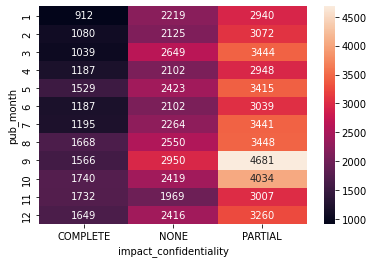

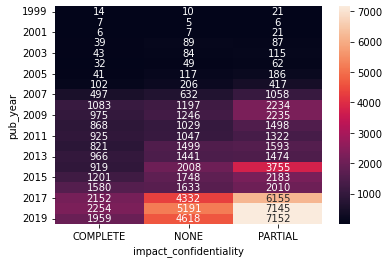

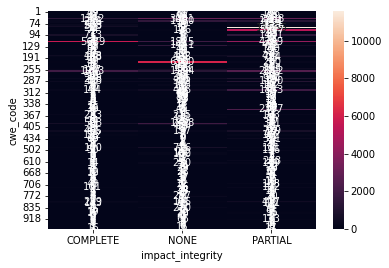

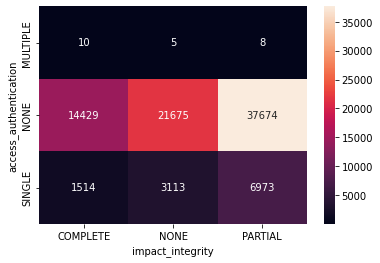

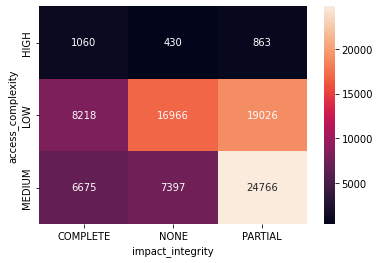

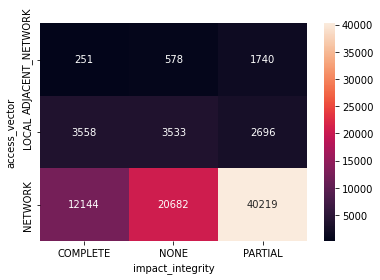

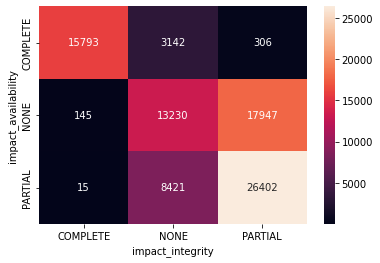

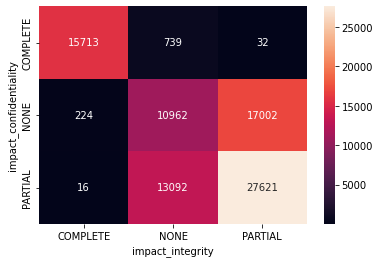

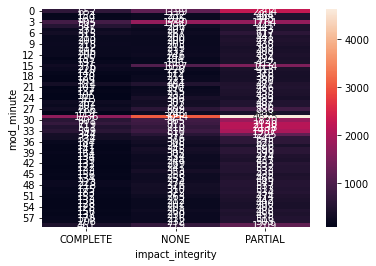

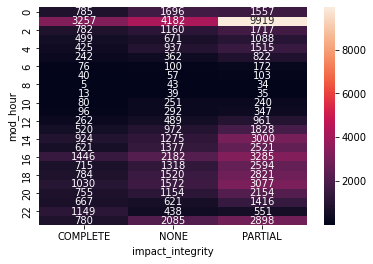

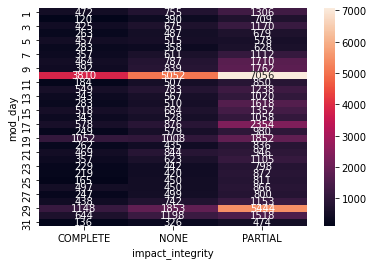

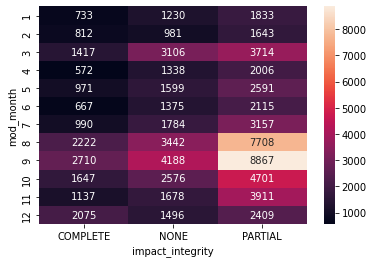

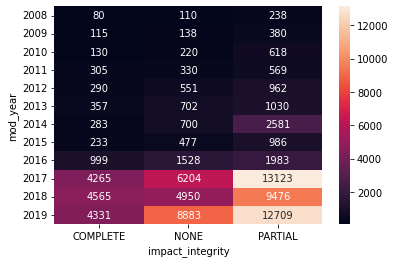

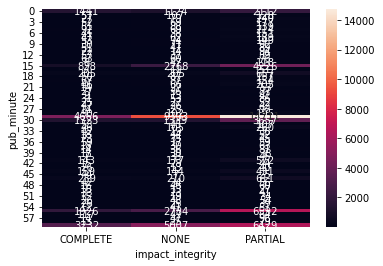

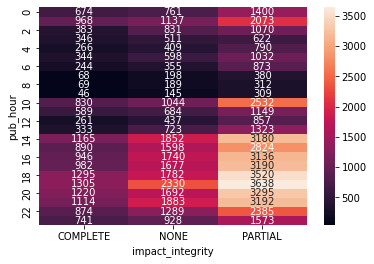

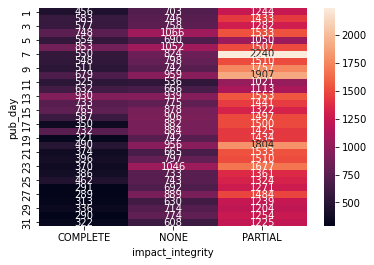

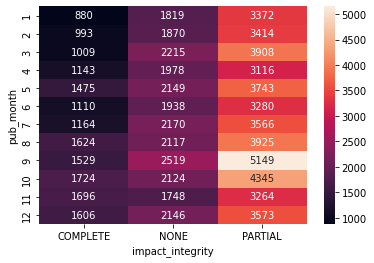

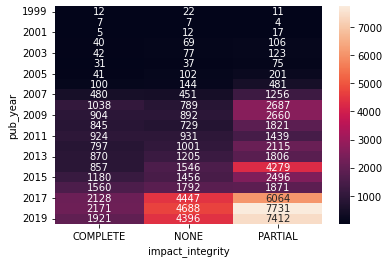

In [33]:
cat_features_display = df_data.select_dtypes(include=['object']).columns
for feature in cat_features_display:
    for feature2 in cat_features:
        if feature2 is not feature:
            plt.figure()
            sns.heatmap(pd.crosstab(df_data[feature2], df_data[feature]), annot=True, fmt='d')
            plt.show()

On remarque ici plusieurs éléments assez intéressants dans l'analyse bivariée des variables catégorielles:
- 'access_complexity' et 'access_authentication' ont une corrélation assez importante, notamment avec des valeurs 'NONE' et 'MEDIUM' de la première autour de la valeur 'NONE' de la seconde
- 'access_complexity' et 'impact_availability' n'ont que peu de corrélation
- les valeurs 'NONE' et 'SINGLE' de 'access_authentication' sont regroupées pour la plupart autour de la valeur 'NETWORK' de 'access_vector'
- une corrélation assez forte est notable entre 'impact_confidentiality' et 'impact_availability'

Ainsi, les colonnes commençant par 'impact' semblent avoir des répartitions siomilaires, de même pour celles commençant par 'access'.

## Corrélation entre les colonnes et la target

### Corrélation avec les valeurs catégorielles entières et continues

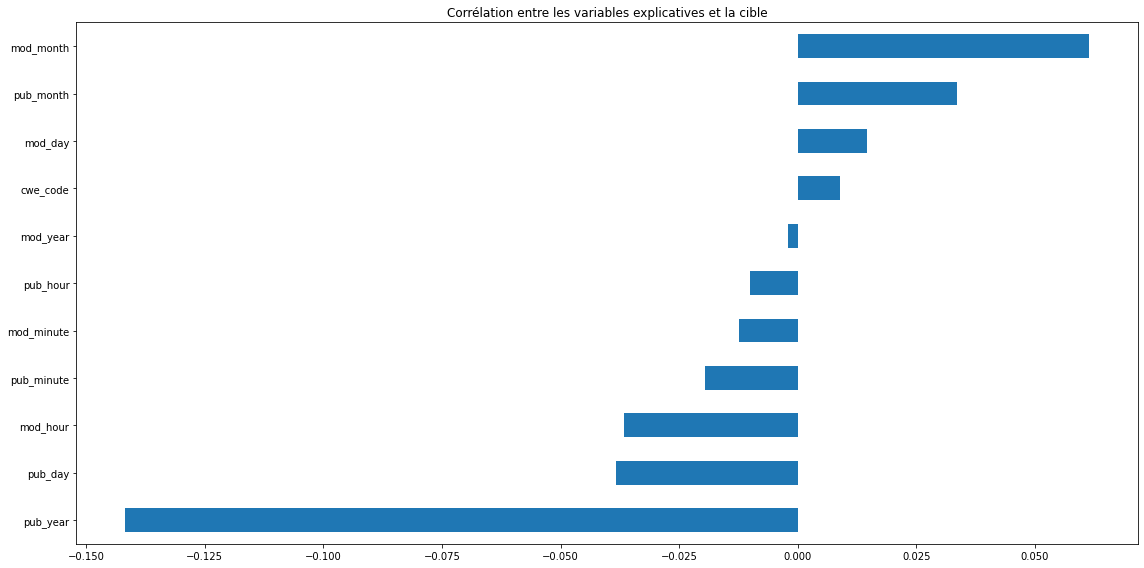

In [34]:
plt.figure(figsize=(16, 8))
corrmat[targetName].sort_values(ascending=True)[:-1].plot(kind='barh')
plt.title("Corrélation entre les variables explicatives et la cible")
plt.tight_layout()
plt.show()

Les variables semblant avoir le plus de corrélation linéaire avec la target sont 'pub_year' et 'mod_month'. L'année de publication n'étant que peu importante car non cyclique contrairement au mois, on peut considérer la première comme peu intéressante. Cependant, si aucune corrélation linéaire ne semble forte à première vue, il est possible qu'une corrélation polynomiale par exemple existe.

# Pré-traitements

Afin d'essayer de trouver une chaîne de traitements permettant de prédire le CVSS, il convient de créer plusieurs versions du dataset qui seraient pré-traitées différemment, avant de les tester pour chaque modèles par la suite.

## Normalisation de la variable cible

In [35]:
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=_RANDOM_STATE_)

Le découpage en deux sets séparés dès le début des pré-traitements nous permettra par la suite d'assurer l'indépendance entre les sets d'entraînement et de test.

In [36]:
df_train=df_train.reset_index(drop=True)

In [37]:
df_test=df_test.reset_index(drop=True)

Afin d'éviter des soucis avec certains pré-traitements, remettre à zéro les index des dataframes.

In [38]:
cat_features_display = df_data.select_dtypes(include=['int64','object']).columns
con_features_display = []

In [39]:
# On verifie que le coefficient d'asymétrie et le coefficient d'applatissment 
print("Skewness: %f" %df_train[targetName].skew())
print("Kurtosis: %f" %df_train[targetName].kurt())

Skewness: 0.256461
Kurtosis: -0.679964


On remarque que les coefficients d'asymétrie et d'aplatissement nous confirment bien que la répartition de la variable target n'est pas normale. Il faut donc réaliser une log-transformation afin d'assurer cette condition nécessaire comme expliqué précédemment durant l'analyse exploratoire des données.

In [40]:
# On importe kstest de stats
loc, scale = norm.fit(df_train[targetName])
n = norm(loc=loc, scale=scale)
print(kstest(df_train[targetName], n.cdf))
# Log transformation
df_train_scaled = df_train.copy()
df_train_scaled[targetName] = np.log1p(df_train[targetName])
df_test_scaled = df_test.copy()
df_test_scaled[targetName] = np.log1p(df_test[targetName])

KstestResult(statistic=0.16435651443511345, pvalue=0.0)


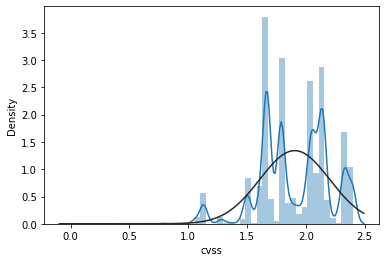

In [41]:
sns.distplot(df_train_scaled[targetName], fit=norm);

In [42]:
print("Skewness: %f" %df_train_scaled[targetName].skew())
print("Kurtosis: %f" %df_train_scaled[targetName].kurt())

Skewness: -0.415541
Kurtosis: 0.010535


On remarque ici que malgré une log transformation des données, la répartition n'est pas tout à fait normale. Cependant, les coefficients semblent meilleurs.

Si cette version du dataset est utilisée par la suite, il faudra penser à inverse la log-transformation afin d'obtenir les vraies valeurs du CVSS, car la plage de données de la target du dataset utilisé en entrée sera modifiée.

## Fonctions de pré-traitements

In [43]:
# Peut prendre StandardScaler, MinMaxScaler, RobustScaler
def scaler(scl, df_train, df_test, con_features = []):
    for feature in con_features:
        df_train[feature] = scl.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
        df_test[feature] = scl.transform(df_test[feature].values.reshape(-1,1)).ravel()
    return df_train, df_test

 Une fonction scaler, comme décrite précédemment, pourra prendre en paramètre un scaler parmi StandardScaler, MinMaxScaler et RobustScaler, pour ensuite réaliser une opération de scaling sur les données continues du dataset.

In [44]:
# Peut prendre LabelEncoder, OneHotEncoder
def encoder(ecd, df_train, df_test, cat_features_to_encode = []):
    # Si on a une colonne catégorielle avec deux valeurs par exemple, on peut utiliser l'encoder
    if type(ecd).__name__ != "OneHotEncoder":
        for feature in cat_features_to_encode:
        # The OneHotEncoder feature needs a new shape, instead of the other encoders
            df_train[feature] = ecd.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
            df_test[feature] = ecd.transform(df_test[feature].values.reshape(-1,1)).ravel()
    else:
        for feature in cat_features_to_encode:
            df_train_to_add = pd.DataFrame(ecd.fit_transform(df_train[feature].values.reshape(-1,1)).toarray())
            df_train_to_add.columns = ecd.get_feature_names_out()
            df_train_to_add.columns = [s.replace('x0' , feature) for s in df_train_to_add.columns]
            
            # Adding columns to train
            for serie in df_train_to_add:
                df_train=pd.concat([df_train, df_train_to_add[serie]], axis=1)
            df_train=df_train.drop([feature],axis=1)

            df_test_to_add = pd.DataFrame(ecd.transform(df_test[feature].values.reshape(-1,1)).toarray())
            df_test_to_add.columns = ecd.get_feature_names_out()
            df_test_to_add.columns = [s.replace('x0' , feature) for s in df_test_to_add.columns]
            # Adding columns to test
            for serie in df_test_to_add:
                df_test=pd.concat([df_test, df_test_to_add[serie]], axis=1)
            df_test=df_test.drop([feature],axis=1)
            
    return df_train, df_test

Une fonction encoder pourra prendre en paramètre un encodeur parmi LabelEncoder et OneHotEncoder, pour ensuite réaliser une opération d'encodage sur les données catégoriques du dataset afin de permettre leur lecture par les algorithmes de classification.

In [45]:
 # Peut prendre KNNImputer, SimpleImputer
def imputer(imp, df_train, df_test, cat_features_to_impute = [], cont_features_to_impute = []):
    # Application de l'imputer sur les variables continues
    for feature in cont_features_to_impute :
        df_train[feature] = imp.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
        df_test[feature] = imp.transform(df_test[feature].values.reshape(-1,1)).ravel()
    # Application de l'imputer sur les variables catégories 
    for feature in cat_features_to_impute :
        df_train[feature] = imp.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
        df_test[feature] = imp.transform(df_test[feature].values.reshape(-1,1)).ravel()
    return df_train, df_test

Une fonction imputer pourra prendre en paramètre un imputer parmi KNNImputer et SimpleImputer, pour remplacer les valeurs manquantes des variables continues (KNN et Simple) ainsi que les valeurs catégoriques (Simple seulement).

In [46]:
def preprocessing(df_train, df_test, targetName, scl = None, imp = None, ecd = None):
    # Deep Copy des dataframe pour garder l'originale intacte
    df_train_tmp = df_train.copy()
    df_test_tmp = df_test.copy()
    # Application des pré-traitements
    df_train_tmp, df_test_tmp = [df_train_tmp, df_test_tmp] if imp is None else imputer(imp, df_train_tmp, df_test_tmp, cat_features, con_features)
    df_train_tmp, df_test_tmp = [df_train_tmp, df_test_tmp] if scl is None else scaler(scl, df_train_tmp, df_test_tmp, con_features)
    df_train_tmp, df_test_tmp = [df_train_tmp, df_test_tmp] if ecd is None else encoder(ecd, df_train_tmp, df_test_tmp, cat_features)
    return df_train_tmp, df_test_tmp

 La fonction de pré-processing prend en paramètre les différents préprocess à appliquer, par catégorie, puis performe un à un les traitements sur une copie du dataset fourni en entrée avant de retourner une nouvelle version pré traitée des training et testing sets. Comme vu précédemment, nous devons imputer les valeurs manquantes (imputer et non supprimer car le nombre de valeur manquantes est négligeable). Pour cela, nous allons employer le KNNImputer.

## Création de combinaisons de pré-traitements

### Chaîne simple

Une première suite de pré-traitements simples servira de base pour comparer les autres chaînes. Il faut donc qu'elle n'augmente pas la complexité du dataframe, tout en assurant les traitements de base, notamment d'encodage.

In [47]:
df_train1, df_test1 = preprocessing(df_train_scaled, df_test, targetName, scl = MinMaxScaler(), imp = SimpleImputer(strategy="most_frequent"), ecd = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [48]:
df_train1.head()

cvss  cwe_code  access_authentication  access_complexity  \
0  0.747222      39.0                    1.0                1.0   
1  0.747222      39.0                    1.0                1.0   
2  0.695488      12.0                    1.0                2.0   
3  0.695488      12.0                    1.0                2.0   
4  0.695488       5.0                    1.0                2.0   

   access_vector  impact_availability  impact_confidentiality  \
0            2.0                  1.0                     2.0   
1            2.0                  1.0                     2.0   
2            2.0                  1.0                     1.0   
3            2.0                  1.0                     1.0   
4            2.0                  1.0                     1.0   

   impact_integrity  mod_minute  mod_hour  mod_day  mod_month  mod_year  \
0               1.0         1.0      19.0     23.0        9.0       9.0   
1               1.0        44.0      13.0     10.0        0.0      11.0   
2               2.0        30.0      17.0     30.0        2.0       1.0   
3               2.0        28.0      20.0      7.0        4.0      11.0   
4               2.0        15.0       4.0     24.0        6.0      11.0   

   pub_minute  pub_hour  pub_day  pub_month  pub_year  
0        29.0      17.0     18.0        9.0      18.0  
1        15.0      19.0     28.0        9.0      20.0  
2        30.0      17.0     30.0        2.0      10.0  
3        15.0      14.0      7.0        2.0      20.0  
4        15.0      17.0     26.0        5.0      20.0

Un premier pré traitement sera un MinMaxScaler (simple), ainsi qu'un OrdinalEncoder. Cet encoder ne splittera pas les colonnes en plusieurs colonnes binaires contrairement à OneHotEncoder, et peut poser des soucis de poids lors de la création de modèles.

### Chaîne simple avec suppression de colonnes

Comme observé lors de l'analyse exploratoire des données, certaines colonnes ont peu d'importance et peuvent se trouver contre productive (comme les années car non cycliques). Il serait donc intéressant de retirer les colonnes les moins utiles afin de vérifier si elles impactent positivement les métriques.

In [49]:
df_train2 = df_train_scaled.copy()
df_test2 = df_test_scaled.copy()
df_train2 = df_train2.drop(['pub_year', 'mod_year'], axis=1)
df_test2 = df_test2.drop(['pub_year', 'mod_year'], axis=1)

In [50]:
df_train2, df_test2 = preprocessing(df_train_scaled, df_test, targetName, scl = StandardScaler(), imp = SimpleImputer(strategy="most_frequent"), ecd = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

On peut également selectionner les K meilleures features parmis celles restantes à l'aide de la méthode SelectKBest.

                   Feature        Score
6         impact_integrity  8914.226212
5   impact_confidentiality  6596.936578
3            access_vector  3870.870270
4      impact_availability  3595.843911
1    access_authentication  2160.657191
16                pub_year  1413.535053
2        access_complexity   737.473694
10               mod_month   280.332642
8                 mod_hour   125.348486
14                 pub_day    71.231978


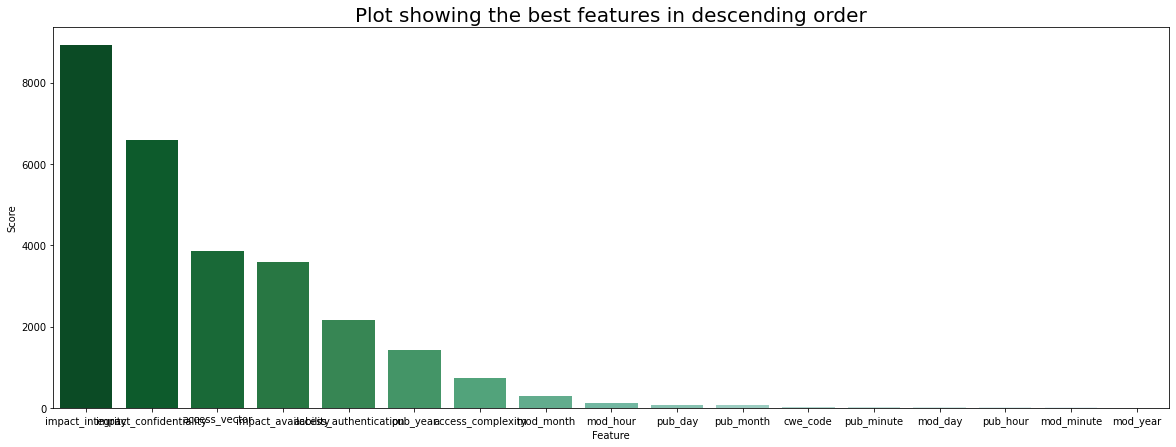

In [51]:
# On coupe le dataset pour utiliser le selecteur
df_train_select = df_train2.drop(targetName, axis=1)
target_train = df_train2[targetName]
# Appliquer une sélection des variables et extraire n variables
n = 10
select = SelectKBest(score_func=f_regression, k=n)
z = select.fit_transform(df_train_select, target_train)
# On extrait les scores de selection pour évaluer l'intérêt
selection_scores = pd.DataFrame(select.scores_)
data_columns = pd.DataFrame(df_train_select.columns)
# Concaténer les deux dataframes
scores = pd.concat([data_columns,selection_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(n,'Score'))
# Visualiser la sélection de variables
scores = scores.sort_values(by="Score", ascending=False)
plt.figure(figsize=(20,7), facecolor='w')
sns.barplot(x='Feature',y='Score',data=scores,palette='BuGn_r')
plt.title("Plot showing the best features in descending order", size=20)
plt.show()

On remarque ici qu'une minorité de colonnes ont un impact sur la valeur de la régression, on peut donc essayer de ne garder que le top 10 des valeurs impactantes.

In [52]:
to_keep = np.array(scores.nlargest(10,'Score')["Feature"])
to_keep = np.append(to_keep,targetName)
df_train2 = df_train2[to_keep]
df_test2 = df_test2[to_keep]

In [53]:
df_train2.head()

impact_integrity  impact_confidentiality  access_vector  \
0               1.0                     2.0            2.0   
1               1.0                     2.0            2.0   
2               2.0                     1.0            2.0   
3               2.0                     1.0            2.0   
4               2.0                     1.0            2.0   

   impact_availability  access_authentication  pub_year  access_complexity  \
0                  1.0                    1.0      18.0                1.0   
1                  1.0                    1.0      20.0                1.0   
2                  1.0                    1.0      10.0                2.0   
3                  1.0                    1.0      20.0                2.0   
4                  1.0                    1.0      20.0                2.0   

   mod_month  mod_hour  pub_day      cvss  
0        9.0      19.0     18.0 -0.382681  
1        0.0      13.0     28.0 -0.382681  
2        2.0      17.0     30.0 -0.799447  
3        4.0      20.0      7.0 -0.799447  
4        6.0       4.0     26.0 -0.799447

### Chaîne complexe

Une chaîne de traitements plus complexe permettra de limiter l'impact des poids de la première méthode, sans se soucier de la complexité et de la taille du dataframe.

In [54]:
df_train3, df_test3 = preprocessing(df_train_scaled, df_test_scaled, targetName, scl = StandardScaler(), imp = SimpleImputer(strategy="most_frequent"), ecd = OneHotEncoder(handle_unknown='ignore'))

In [55]:
df_train3.head()

cvss  cwe_code_1  cwe_code_16  cwe_code_17  cwe_code_18  cwe_code_19  \
0 -0.382681         0.0          0.0          0.0          0.0          0.0   
1 -0.382681         0.0          0.0          0.0          0.0          0.0   
2 -0.799447         0.0          0.0          0.0          0.0          0.0   
3 -0.799447         0.0          0.0          0.0          0.0          0.0   
4 -0.799447         0.0          0.0          0.0          0.0          0.0   

   cwe_code_20  cwe_code_21  cwe_code_22  cwe_code_59  cwe_code_74  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          1.0          0.0          0.0          0.0          0.0   

   cwe_code_77  cwe_code_78  cwe_code_79  cwe_code_88  cwe_code_89  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          1.0          0.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   cwe_code_90  cwe_code_91  cwe_code_93  cwe_code_94  cwe_code_99  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   cwe_code_113  cwe_code_116  cwe_code_118  cwe_code_119  cwe_code_120  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_123  cwe_code_125  cwe_code_129  cwe_code_131  cwe_code_134  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_172  cwe_code_178  cwe_code_184  cwe_code_185  cwe_code_189  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_190  cwe_code_191  cwe_code_193  cwe_code_199  cwe_code_200  \
0           0.0           0.0           0.0           0.0           1.0   
1           0.0           0.0           0.0           0.0           1.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_203  cwe_code_209  cwe_code_216  cwe_code_252  cwe_code_254  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_25

In [56]:
df_train3.shape

(71624, 473)

Une troisème combinaison de préprocessus permet d'introduire le OneHotEncoder. Ce dernier explose les colonnes catégorielles en colonnes binaires, afin que la valeur entière des labels n'impacte pas les résultats de certaines modélisations, où des valeurs entières plus importantes que d'autres pouvaient avoir un poids plus fort, alors que ces entiers ne sont que des encodages de catégories.

# Modélisation

Maintenant que les données sont pré-traités, elles sont aptes à être utilisées afin de créer des modèles répondants à notre problématique de départ. Pour améliorer au maximum nos résultats, on créera plusieurs modélisations, puis on déterminera les performances de chaque modèles. Il faudra également utiliser chaque pré-process sur chaque modèle, afin de déterminer la meilleure chaîne de traitement de la donnée.

In [57]:
def testModel(df_train, df_test, targetName, model, showMetrics = False):
    # On sépare la target des features
    y_train =  df_train[targetName]
    y_test =  df_test[targetName]
    X_train = df_train.drop(targetName, axis=1)
    X_test = df_test.drop(targetName, axis=1)
    # Fitting du modèle
    model.fit(X_train, y_train)
    # Obtention des résultats du modèle sur le testing set et sur le training set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Obtention des métriques et affichage
    rmse=np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae=mean_absolute_error(y_test, y_pred_test)
    medae=median_absolute_error(y_test, y_pred_test)
    print("--> rmse =", rmse)
    print("--> mae =", mae)
    print("--> medae =", medae)
    # Possibilité de changer la métrique
    toReturn = medae
    if showMetrics:
        N, train_score, val_score = learning_curve(model, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=5, 
                                                  scoring='neg_mean_squared_error',
                                                  train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(14,7))
        plt.title("Learning curve du modèle: " + str(model.__class__.__name__))
        plt.plot(N, train_score.mean(axis=1), label='Train Score')
        plt.plot(N, val_score.mean(axis=1), label='Validation Score')
        plt.legend()
        
    return toReturn

La fonction testModel permet d'appliquer un modèle instantié passé en paramètre aux données d'un jeu de données pré-traité passé également en paramètre. Il sera alors très simple de boucler sur tous les modèles et les pré traitements afin de les comparer et ainsi d'obtenir la meilleure chaîne de pré-traitements et le meilleur modèle.

Les 3 métriques choisies qui permettent d'évaluer les modèles sont :
- racine carré de l'erreur quadratique moyenne, soit la racine carrée de la variance calculée
- erreur moyenne absolue, qui détermine la distance moyenne séparant les résultats prédits de la vraie valeur
- erreur médiane absolue, qui détermine la distance médiane séparant les résultats prédits de la vraie valeur

Afin de s'affranchir des erreurs aberrantes, nous préfèrerons ici nous baser sur la médiane.

In [58]:
 def getBestChain(l_preprocess, l_models):
    chosen = None
    tableResult = []
    print("Training")
    for p in l_preprocess:
        print("> Using preprocess:", p)
        df_train = l_preprocess[p]["train"]
        df_test = l_preprocess[p]["test"]
        targetName = l_preprocess[p]["target"]
        for m in l_models:
            print("-> Training on model:", m)
            result = {"model": m, "preprocess": p}
            result["score"] = testModel(df_train, df_test, targetName, l_models[m], showMetrics = False)
            tableResult.append(result)
    tableResult = sorted(tableResult, key=lambda d: d['score'], reverse=True)
    print(tableResult)
    return tableResult[0]

 La fonction getBestChain va itérer sur tous les préprocess et tous les modèles afin de trouver la meilleure chaîne de traitement, avec l'erreur médiane absolue comme référence pour la métrique.

In [61]:
# Pré-traitements à tester
l_preprocess = {"1": {"train": df_train1, "test": df_test1, "target": targetName},
                "2": {"train": df_train2, "test": df_test2, "target": targetName},
                "3": {"train": df_train3, "test": df_test3, "target": targetName}}
# Modèles à tester
l_models = {"Ridge": Ridge(random_state=_RANDOM_STATE_),
            "Ridge06": Ridge(alpha=0.06, random_state=_RANDOM_STATE_),
            "Ridge10": Ridge(alpha=10, random_state=_RANDOM_STATE_),
            "Lasso": Lasso(),
            "LinearSVR": LinearSVR(random_state=_RANDOM_STATE_),
            # "SVR" : SVR(), # Très long à executer pour des résultats moyens
            "SGDRegressor" : SGDRegressor(random_state=_RANDOM_STATE_),
            "GradientBoostingRegressor" : GradientBoostingRegressor(random_state=_RANDOM_STATE_),
            "RandomForestRegressor": RandomForestRegressor(random_state=_RANDOM_STATE_),
            "LinearRegression": LinearRegression()
            }
bestResult = getBestChain(l_preprocess, l_models)

Training
> Using preprocess: 1
-> Training on model: Ridge
--> rmse = 1.9025306057114988
--> mae = 1.7242452115649622
--> medae = 1.662370996227533
-> Training on model: Ridge06
--> rmse = 1.9025300813867134
--> mae = 1.7242451667815806
--> medae = 1.6623722667608867
-> Training on model: Ridge10
--> rmse = 1.90253562200261
--> mae = 1.7242456400419854
--> medae = 1.6623588329742602
-> Training on model: Lasso
--> rmse = 1.9170782150770287
--> mae = 1.7256380970084615
--> medae = 1.6240631159767067
-> Training on model: LinearSVR
--> rmse = 2.0016550821915033
--> mae = 1.830272323527449
--> medae = 1.8202729692135373
-> Training on model: SGDRegressor
--> rmse = 4739862.782033299
--> mae = 3938575.3078775685
--> medae = 3598675.0246921857
-> Training on model: GradientBoostingRegressor
--> rmse = 1.8692201701736617
--> mae = 1.72372571138184
--> medae = 1.6631306949110445
-> Training on model: RandomForestRegressor
--> rmse = 1.867441236062628
--> mae = 1.7240820447510503
--> medae = 1

Les résultats varient énormément selon les pré-traitements, et un peu moins selon les modèles. Cependant, on localise ici une chaîne de traitement minorant l'erreur médiane absolue : random forest avec la 3ème chaîne de pré-traitement.

On pourra maintenant essayer d'améliorer les résultats obtenus en réalisant une optimisation des paramètres de ce dernier.

# Evaluation

Afin de vérifier si le modèle n'est pas en overfitting, on peut afficher sa courbe d'apprentissage.

In [80]:
def evaluation(model, X_train, y_train, X_test, y_test):
    N, train_score, val_score = learning_curve(model, 
                                              X_test, 
                                              y_test, 
                                              cv=5, 
                                              scoring='neg_mean_squared_error',
                                              train_sizes=np.linspace(0.1, 1, 5))
    plt.figure(figsize=(14,7))
    plt.title("Learning curve du modèle: " + str(model.__class__.__name__))
    plt.plot(N, train_score.mean(axis=1), label='Train Score')
    plt.plot(N, val_score.mean(axis=1), label='Validation Score')
    plt.legend()
    
    

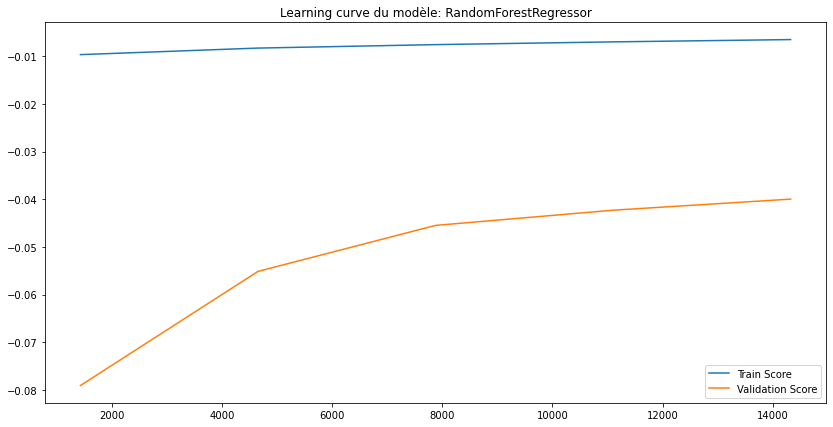

In [81]:
X_train = df_train3.drop(targetName, axis = 1)
y_train = df_train3[targetName]

X_test = df_test3.drop(targetName, axis = 1)
y_test = df_test3[targetName]
model = RandomForestRegressor(random_state=_RANDOM_STATE_)
evaluation(model, X_train, y_train, X_test, y_test)

On remarque ici que le modèle n'est pas en overfitting, ce qui est donc positif pour notre problème. En effet, les deux courbes semblent converger, et la courbe de validation a un score strictement croissant, ce qui signifie que les résultats sur le set de validation s'améliore. Cependant, on pourra relancer cette évaluation en passant en paramètre le testing set, qui est 4 fois plus important que le testing set, si plus de ressources de calcul sont disponibles.

# Optimisation

Afin d'améliorer encore plus les résultats, il est possible de réaliser une optimisation des paramètres sur le modèle choisi. Ici, il est possible d'optimiser divers paramètres de RandomForestRegressor :
- n_estimators, le nombre d'arbres par forêts, donc le nombre d'estimateurs
- max_depth, la profondeur maximale de chaque arbre (risque d'être exponentiel en complexité)
- min_samples_split, nombre minimum de samples du dataset pour couper l'expérimentation en un nouveau noeud

D'autres paramètres encore plus précis peuvent également être optimisés. Cependant, ici, nous nous limiterons au nombre d'estimateurs, car sinon la durée de l'expérimentation serait trop longue (limite matérielle).

In [62]:
def optimisation(model, x_train, y_train, param_opti, metric, interv_min, interv_max, pas):
    param_grid={param_opti:  np.arange(interv_min, interv_max, pas)}
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=metric)
    grid.fit(x_train, y_train)
    print("Le meilleur score obtenu est: ", grid.best_score_)
    print("La meilleure valeur pour le paramètre à optimiser est: ", grid.best_params_)
    
    param_range = np.arange(interv_min, interv_max, pas)
    
    train_score, val_score = validation_curve(model, 
                                              x_train,
                                              y_train,
                                              param_name=param_opti, 
                                              param_range=param_range, 
                                              cv=5,
                                             scoring=metric)

    plt.figure(figsize=(12, 4))
    plt.plot(param_range, train_score.mean(axis = 1), label = 'train')
    plt.plot(param_range, val_score.mean(axis = 1), label = 'validation')
    plt.legend()
    plt.title("Courbe de validation pour " + str(model.__class__.__name__))
    plt.ylabel('score')
    plt.xlabel('Paramètre de régularisation: '+param_opti)
    plt.show()
    
    return grid.best_estimator_

In [ ]:
X_train = df_train3.drop(targetName, axis = 1)
y_train = df_train3[targetName]

X_test = df_test3.drop(targetName, axis = 1)
y_test = df_test3[targetName]
model = RandomForestRegressor(random_state=_RANDOM_STATE_)
grid_result = optimisation(model, X_train, y_train, "n_estimators", "r2", 10, 500, 100)

# Conclusion

En conclusion, le dataset est malheureusement assez bruité et peu de corrélations fortes apparaissent avec la valeur de la target. Cependant, nous avons pu réaliser une chaîne de traitements donnant des résultats satisfaisants, avec une confiance d'environ 2%. L'utilisation de OneHotEncoder augmentant la complexité, les temps d'entraînements des modèles s'en retrouvent multipliés, mais permettent de donner de très bons résultats pour la majorité des modèles, qui plus est avec RandomForestRegressor.

On peut également proposer des pistes d'amélioration :
- Ajouter de nouveaux modèles
- Ajouter de nouveaux pré-traitements
- Introduire du NLP sur la colonne summary avec un modèle Tensorflow
- Essayer l'approche en classes (classification)
- Améliorer la qualité du dataset